# Applied Data Science - Exercise 4

This is the fourth exercise in the course T-786-APDS Applied Data Science at Reykjavik University.

## Preparation

Please read chapters 2 and 5 of the *Interpretable machine learning* book and chapter 9 of the *Hands-On Machine Learning* book before the lab.


## Task

In the last exercise, we trained some machine learning models on our second hand car listing data and got an idea of the prediction error on the training set. In this exercise we are going to try to understand what is going on behind the curtains: How is our price-prediction model deciding what to predict?

In the last exercise we also tried to predict which cars are classified as luxury cars in the MSRP dataset. This time we are going to dig deeper into the MSRP dataset using unsupervised learning and figure out if it contains some obvious clusters of car types and whether we can detect outliers.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import sys

In [2]:
# Check python version.
# This code should run for python version >=3.6

print("python", sys.version)

python 3.12.5 (tags/v3.12.5:ff3bc82, Aug  6 2024, 20:45:27) [MSC v.1940 64 bit (AMD64)]


## Model interpretation

You will now try out different methods for model interpretation on some of the regression models trained on the `vehicles.csv` data in exercise 2.

In the steps below, we define decision tree and random forest models and train them on a small training set. Feel free to use the models you trained in exercise 2 (you can use the [pickle](https://wiki.python.org/moin/UsingPickle) Python module to save your model and load it into this notebook runtime).

**Hint:** If you get stuck, take a look at the [Model interpretation notebook](https://github.com/MariaOskarsdottir/AppliedDataScience/blob/main/Model%20interpretation.ipynb) from the lecture.

**Hint:** Lots of these methods will complain if you try to feed them sparse matrices (`scipy.sparse`). You can use the `.toarray()` method to change one into a normal NumPy array.

We repeat the same preprocessing steps as before:

In [3]:
vehicles = pd.read_csv("../data/vehicles.csv", index_col=0)

In [4]:
reduced_df = vehicles.copy()
reduced_df = reduced_df[reduced_df['price'] > 0]
reduced_df = reduced_df[reduced_df['price'].notna()]
reduced_df = reduced_df[reduced_df['price'] < 1000000]
reduced_df = reduced_df[~((reduced_df.manufacturer.isnull()) & (reduced_df.manufacturer.isnull()))]
reduced_df = reduced_df.drop(columns=[
    'county', 
    'id', 
    'region_url', 
    'url', 
    'image_url',
    'VIN'
])

In [5]:
from sklearn.model_selection import train_test_split

vehicles_train_set, vehicles_test_set = train_test_split(reduced_df, test_size=0.1, random_state=123)
vehicles_train_set, vehicles_val_set = train_test_split(vehicles_train_set, test_size=0.95)

**Note:** In the next couple of exercises we are going to continue trying to predict the price. Since we have not finished modeling, we will continue to avoid looking at the test set. Note also that in every exercise we have used `random_state=123`, so we are always making the same training/test split.

In [6]:
def preprocess(df_in):
    
    df = df_in.copy()
    
    N = 50
    topN_models = df.model.value_counts().head(N).index.to_numpy()
    df.loc[~df['model'].isin(topN_models),'model'] = 'unknown'
    top_models = list(vehicles_train_set.model.unique())
    
    df = df.drop(columns=[
        'size', 
        'drive', 
        'lat', 
        'long', 
        'posting_date', 
        'paint_color', 
        'description',
        'state',
        'region'
    ])
    
    df.loc[~df['model'].isin(top_models),'model'] = 'unknown'
    
    df = df.dropna(subset=['year', 'odometer','manufacturer'])
    df.fillna(
        {
            'type':'unknown', 
            'title_status':'clean', 
            'fuel':'gas', 
            'cylinders':'unknown', 
            'transmission':'automatic', 
            'condition':'good'
        }, inplace=True)    
    
    X = df.drop('price', axis=1)
    y = df['price'].copy()
    
    return(X,y)

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

X, y = preprocess(vehicles_train_set)

num_attribs = list(X.select_dtypes('number'))
cat_attribs = list(X.select_dtypes('object'))


pipeline = ColumnTransformer([
    ('num', StandardScaler(), num_attribs),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_attribs)
])

X_prepared = pipeline.fit_transform(X)

### Visualizing a decision tree

In [8]:
# We train a decision tree regressor with a depth
# of 3 on the training data:

from sklearn.tree import DecisionTreeRegressor

tree_class = DecisionTreeRegressor(max_depth=3)
tree_class.fit(X_prepared, y)

DecisionTreeRegressor(max_depth=3)

In [9]:
# Since the one-hot encoding messed up our column names,
# we need to create a new array of column names.
# Verify that this works by checking the code and
# printing the resulting array (all_attributes).

# Fit the OneHotEncoder on the categorical subset
ohe = pipeline.transformers[1][1]
cat_cols = X.select_dtypes('object').columns
ohe.fit(X[cat_cols])

# Build the full feature‐name list
num_cols = X.select_dtypes('number').columns.to_numpy()
cat_feature_names = ohe.get_feature_names_out(cat_cols)

all_attributes = np.concatenate([
    num_cols,
    cat_feature_names
])

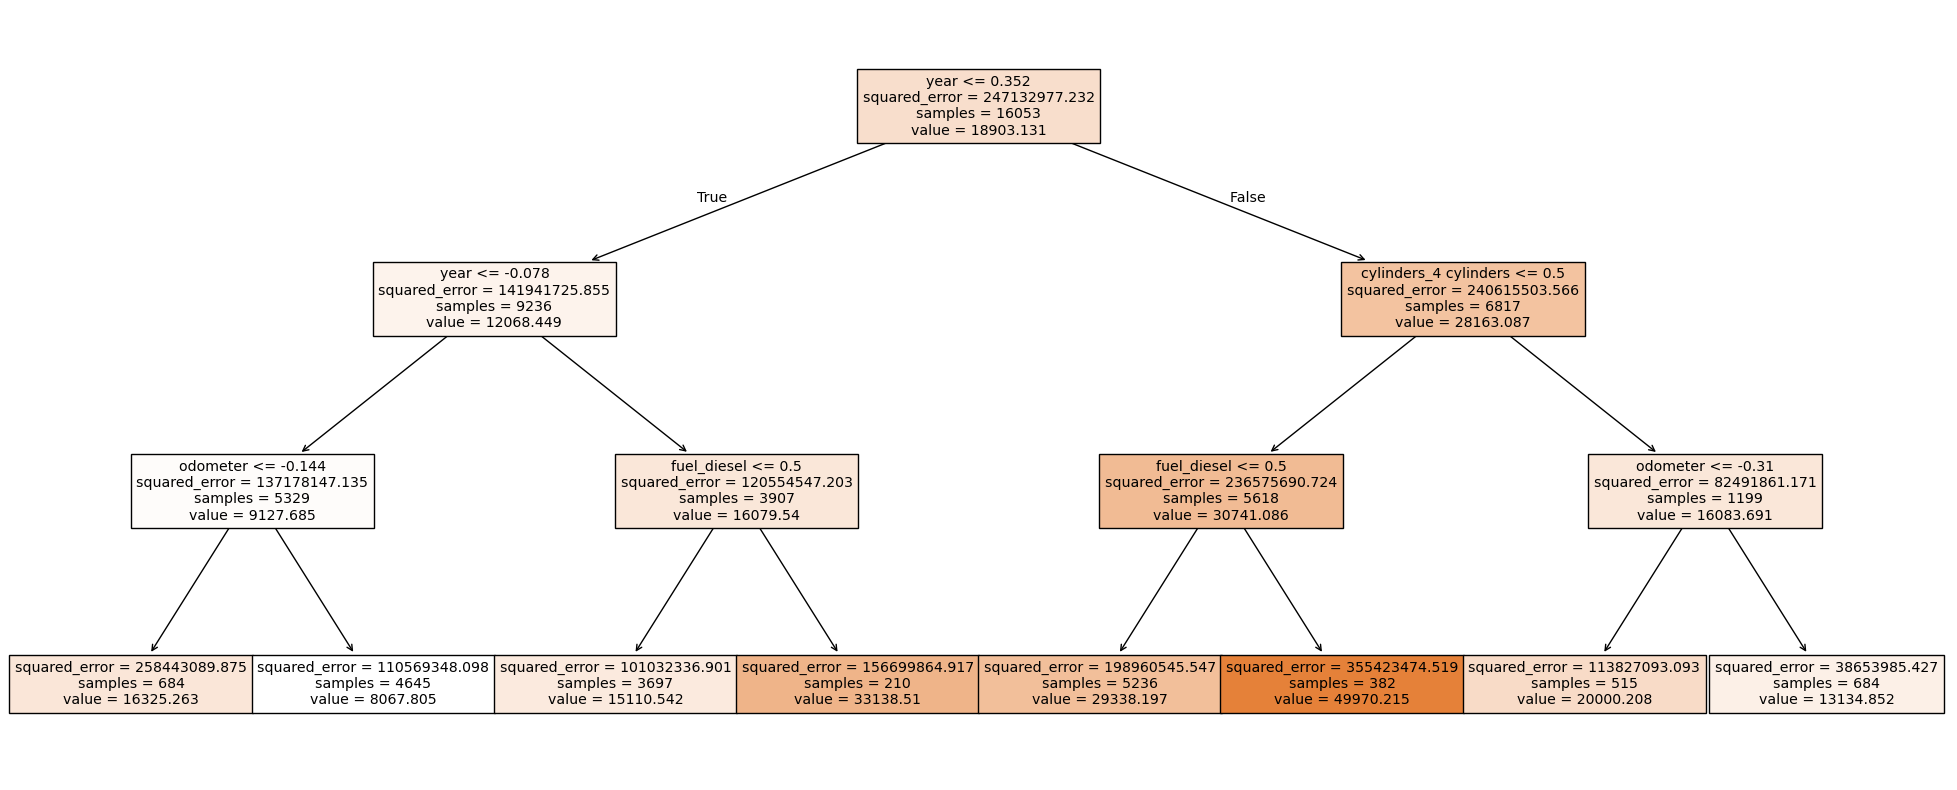

In [10]:
# Use the `sklearn.tree.plot_tree` method to plot 
# the decision tree. Call it with `feature_names=all_attributes`.

from sklearn.tree import plot_tree

plt.figure(figsize=(25,10))
plot_tree(tree_class, feature_names=all_attributes, filled=True)
plt.show()

**Task:** Study the tree plot and make sure you understand what it shows.

### Interpreting a random forest model

In [11]:
# Here we define a random forest regressor model and train
# it on our training data. You can use a random forest model 
# you trained in exercise 2 instead if you want.

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

rf_reg = RandomForestRegressor(n_estimators=50, max_features=5)
est = rf_reg.fit(X_prepared, y)

#rf_reg = pickle.load(open('..models/rf_reg.pkl', 'rb'))


**Task:** Plot a feature importance plot for the model using the `feature_importances_` attribute of `est`.

In [12]:
ohe_categories = pipeline.named_transformers_["cat"].categories_
new_ohe_features = [f"{col}__{val}" for col, vals in zip(cat_attribs, ohe_categories) for val in vals]
all_features = num_attribs + new_ohe_features

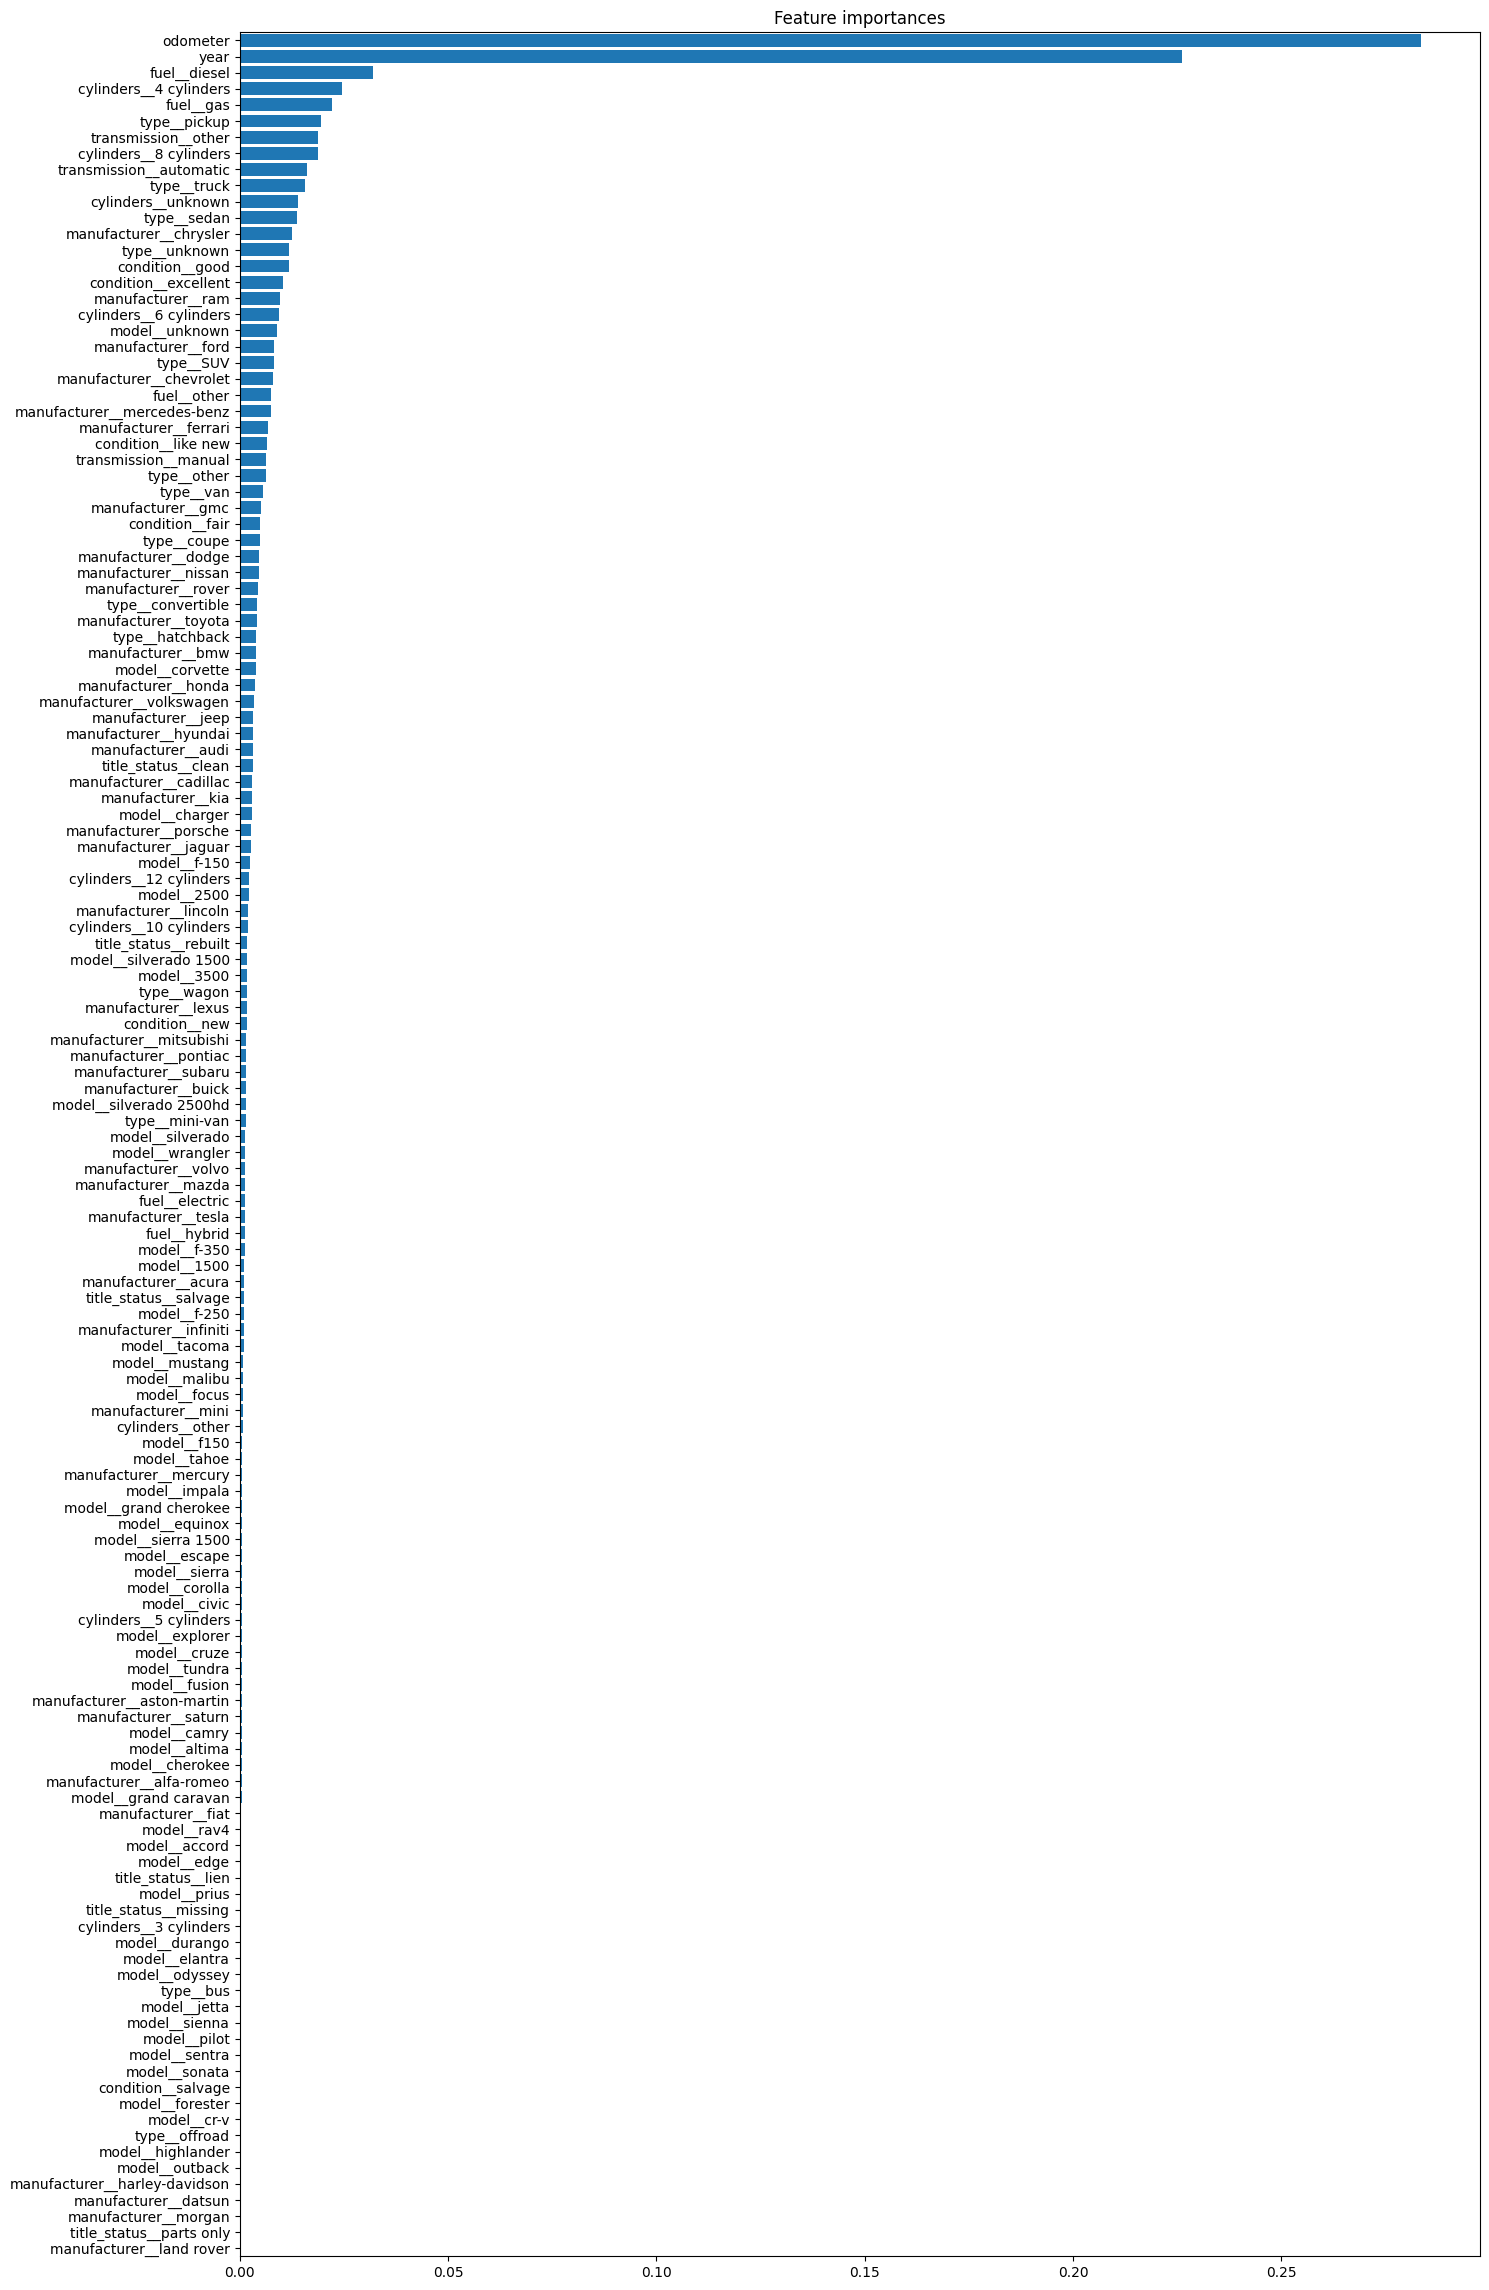

In [13]:
# Plot the feature importances of the random forest regressor
importances = est.feature_importances_
sorted_idx = importances.argsort()
labels = list( np.array(all_features, dtype=object)[sorted_idx] )
y_ticks = np.arange(0, len(all_features))
fig, ax = plt.subplots(figsize=(15, 23))
ax.barh(y_ticks, importances[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_yticklabels(labels)
ax.set_ylim(y_ticks[0] - 0.5, y_ticks[-1] + 0.5)
plt.title("Feature importances")
plt.tight_layout()
plt.show()

**Question:** What do you find interesting about this plot? What are the five most important features according to the plot?

**Answer:** `The most important features are 'year', 'odometer', 'fuel', 'cylinders' and 'transmission', although year and odometer contribute the far most. That does not surprise me, but what does surprise me is that fuel type matters a lot.`

**Task:** Use `sklearn.inspection.permutation_importance` to plot a permutation feature importance plot for the model. Make sure you evaluate on the training set.

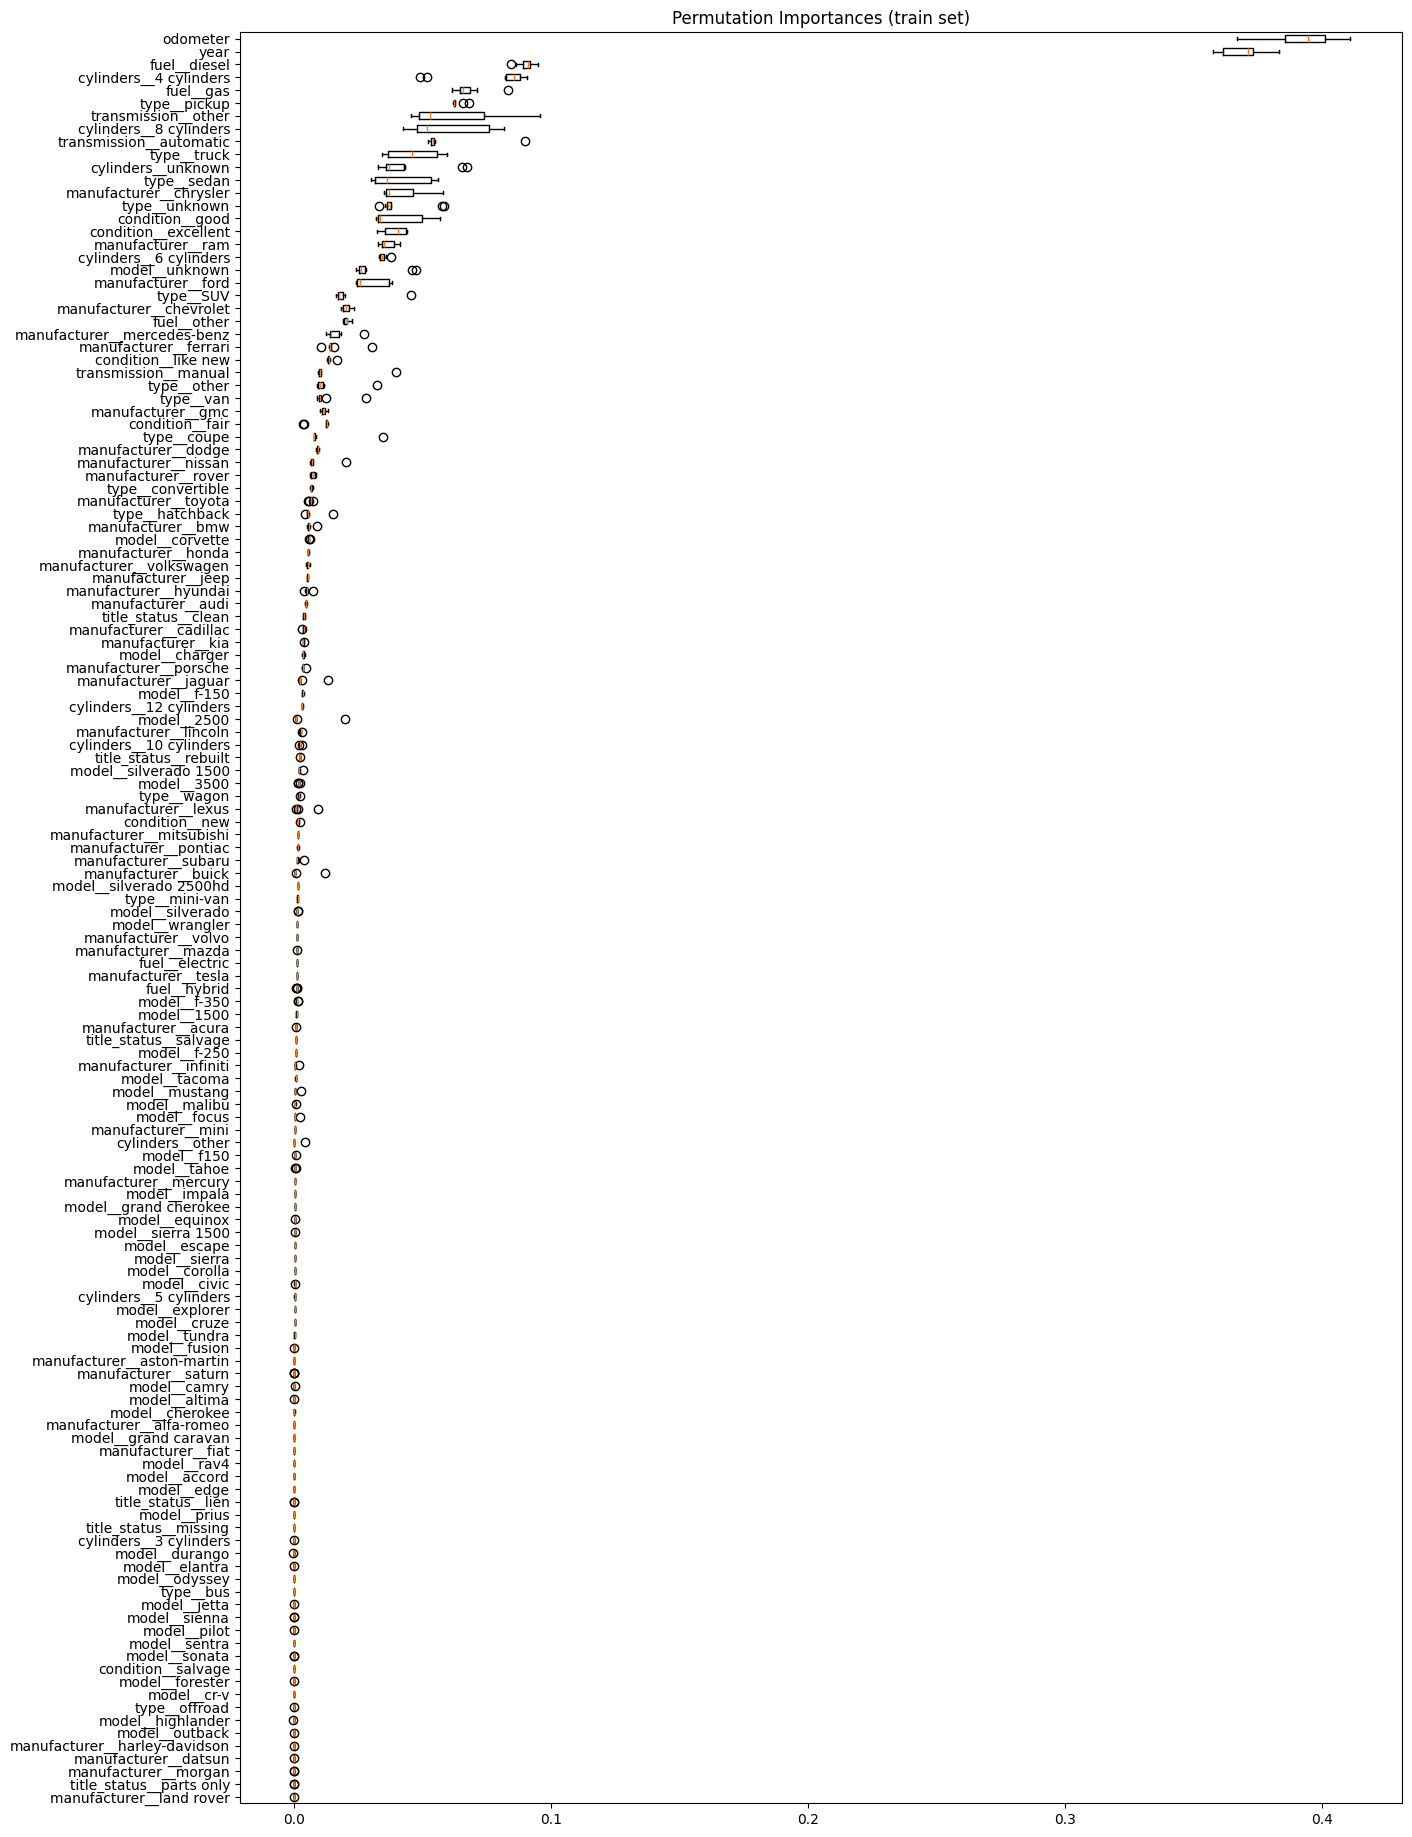

In [14]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rf_reg, X_prepared.toarray(), y, n_repeats=10, n_jobs=-1
)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(15, 23))
ax.boxplot(result.importances[sorted_idx].T, vert=False, tick_labels=labels)
ax.set_title("Permutation Importances (train set)")
plt.show()

**Question:** How does the permutation importance plot compare to the feature importance plot above? What are the five most important features according to the permutation importance plot?

**Answer:** `It's similar, the far most important feature is year, then odometer. The next three are fuel, cylinders and transmission.`

**Task:** Create three partial dependence plots: One to show the marginal effect of `year` on the price, one for `odometer` and one for both `year` and `odometer`.

**Hint:** `year` is the first feature column in `X_prepared` and `odometer` is the second.

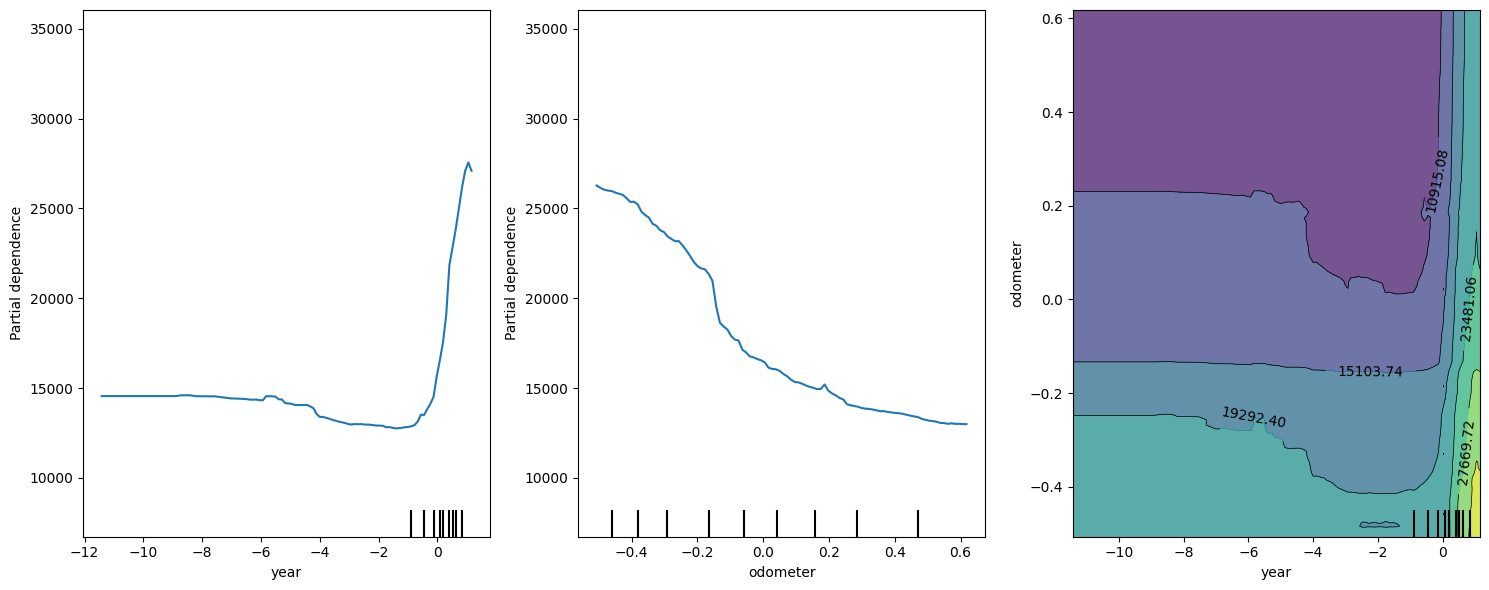

In [15]:
from sklearn.inspection import PartialDependenceDisplay

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
PartialDependenceDisplay.from_estimator(est, X_prepared.toarray(), features=[0, 1, (0, 1)], ax=ax, feature_names=all_features)

plt.tight_layout()
plt.show()


**Task:** Create two *ICE* (Individual Conditional Expectation) plots, one for the `year` feature and one for `odometer`. Use a `subsample` of 50.

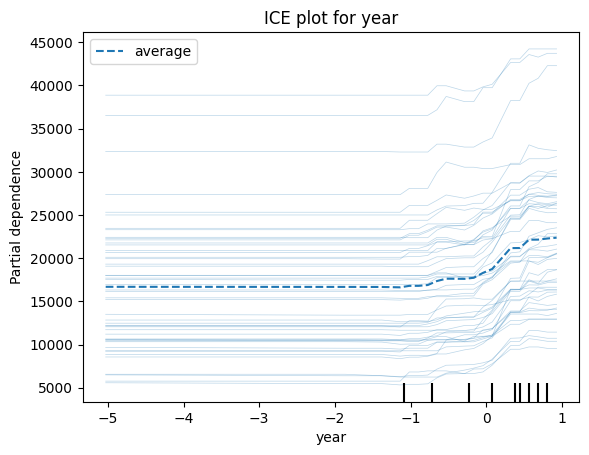

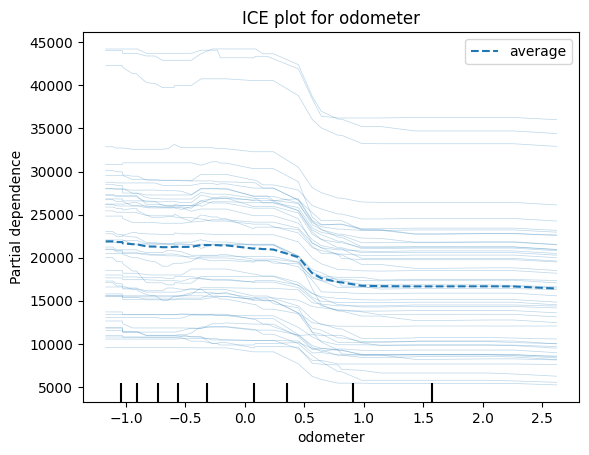

In [ ]:
from sklearn.inspection import partial_dependence

sample50 = vehicles_train_set.sample(50, random_state=123)
X_sample, y_sample = preprocess(sample50)
X_sample_prepared = pipeline.fit_transform(X_sample)
rf_reg_sample = RandomForestRegressor(n_estimators=50, max_features=5)
est_sample = rf_reg_sample.fit(X_sample_prepared, y_sample)

# create ICE plot for year
display = PartialDependenceDisplay.from_estimator(est_sample, X_sample_prepared.toarray(), features=[0], kind="both", feature_names=all_features)
plt.title("ICE plot for year")
plt.show()

PartialDependenceDisplay.from_estimator(est_sample, X_sample_prepared.toarray(), features=[1], kind="both", feature_names=all_features)
plt.title("ICE plot for odometer")
plt.show()

**Question:** What observations can you make about the partial dependence and ICE plots?

**Answer:** `They show the dependence between year and price, and odometer and price.`
There seems to be a time, recently, where the prices go up. Maybe cars of year 2020 were higher in prices and that have kept that way since.

The odometer plot shows that prices go down, the higher the odometer, although there is a stop in the middle where price keeps the same. What is interesting is that there seems to be a bit of a rise in the start of the plot.

**Task:** Use *LIME* (Local Interpretable Model-agnostic Explanations) to explain model's prediction of a random training example.

In [17]:
import lime
from lime import lime_tabular

Prediction: 19688.0
LIME prediction: 19688.0


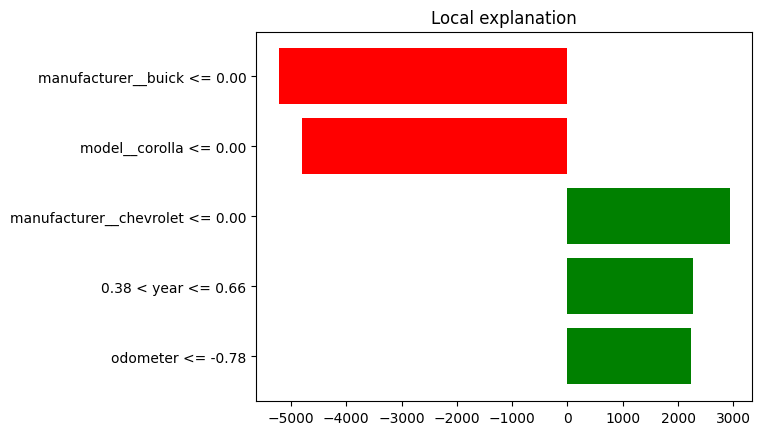

In [22]:
X_sample_dense = X_sample_prepared.toarray()

explainer_lime = lime_tabular.LimeTabularExplainer(np.array(X_sample_dense),
                                 mode="regression",
                                 feature_names=all_features,
                                 categorical_names=new_ohe_features,
                                 categorical_features=cat_attribs,
                                 random_state=123)

np.random.seed(123)
i = 0
exp_lime = explainer_lime.explain_instance(
    X_sample_dense[i], 
    predict_fn=est_sample.predict, 
    num_features=5
)

print("Prediction:", est_sample.predict(X_sample_dense[i].reshape(1, -1))[0])
print("LIME prediction:", exp_lime.predicted_value)

%matplotlib inline
fig = exp_lime.as_pyplot_figure()


**Question:** You picked a random training example which the random forest model predicted a price for. Can you use *LIME* to explain why the model predicted this price for this training example?

**Answer:** `Yes, it shows what features contribute to the prediction. The prediction and the LIME prediction is the same.`

**Optional task:** Use the various different types of *SHAP* plots (Force, Beeswarm, dependence plots) to further interpret the random forest model.

In [129]:
import shap
explainer = shap.Explainer(est_sample)
shap_values = explainer.shap_values(X_sample_prepared.toarray(), approximate=False, check_additivity=False)

**Beeswarm**

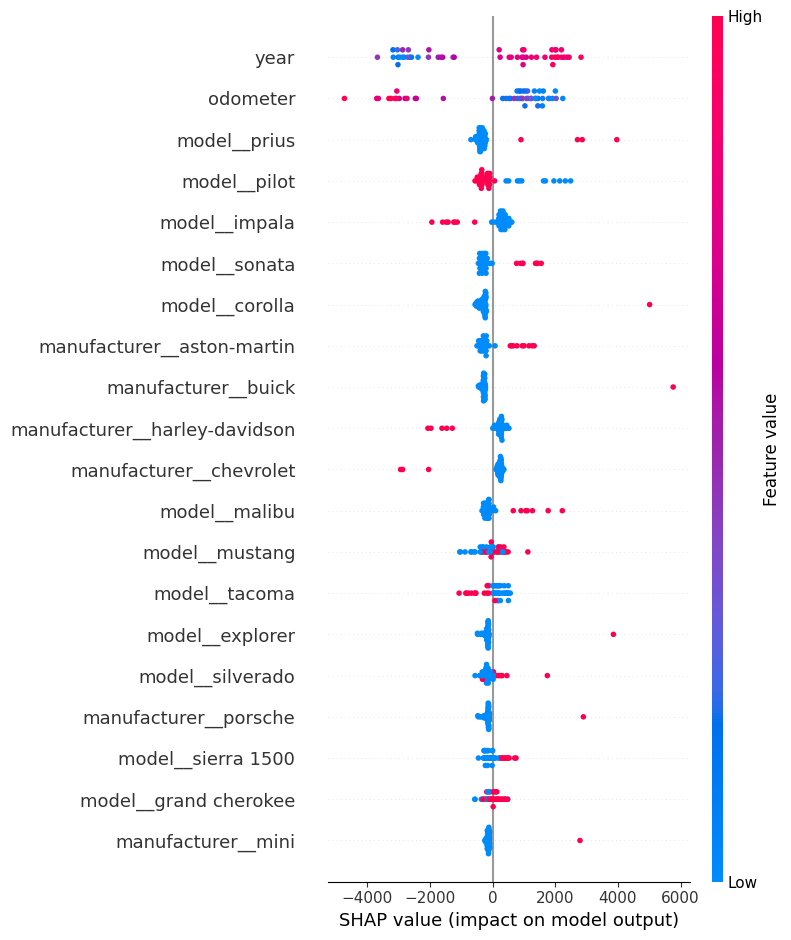

In [133]:
shap.summary_plot(shap_values, X_sample_prepared.toarray(), feature_names=all_features, rng=123)


**Waterfall**

In [141]:
shap.initjs()
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[0], X_sample_prepared.iloc[0])


AttributeError: 'csr_matrix' object has no attribute 'iloc'

**Force**

In [138]:
shap.initjs()
shap.plots.force(explainer.expected_value, shap_values[1:1000], X_sample_prepared.iloc[1:1000])

AttributeError: 'csr_matrix' object has no attribute 'iloc'

**Dependence**

In [139]:
shap.dependence_plot("median_price", shap_values, X_sample_prepared)

ValueError: Could not find feature named: median_price

## Unsupervised learning

We will now move on to the MSRP dataset, this time to do unsupervised learning. This means we do not use any column as a target variable, but instead try to find patterns in the data.

We read in the data and preprocess as before:

In [27]:
msrp_df = pd.read_csv("../data/msrp_data.csv")

In [28]:
for col in msrp_df.columns:
    new_col = '_'.join(col.lower().split(' '))
    msrp_df.rename({col: new_col}, inplace=True, axis=1)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [30]:
msrp_train_set, msrp_test_set = train_test_split(
    msrp_df, 
    test_size=0.3, 
    random_state=123
)
msrp_train_df = msrp_train_set.copy()

In [31]:
msrp_train_df.head(5)

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
4302,Infiniti,EX,2012,premium unleaded (recommended),297.0,6.0,AUTOMATIC,rear wheel drive,4.0,"Crossover,Luxury,Performance",Midsize,4dr SUV,24,17,190,38100
2264,GMC,Canyon,2012,regular unleaded,185.0,4.0,AUTOMATIC,four wheel drive,2.0,NaN,Compact,Regular Cab Pickup,23,17,549,22385
2373,Porsche,Cayenne,2016,premium unleaded (required),440.0,6.0,AUTOMATIC,all wheel drive,4.0,"Crossover,Luxury,High-Performance",Midsize,4dr SUV,23,16,1715,95500
7413,Chrysler,Pacifica,2017,regular unleaded,287.0,6.0,AUTOMATIC,front wheel drive,4.0,NaN,Midsize,Passenger Minivan,28,18,1013,37895
6872,Lincoln,MKT,2015,regular unleaded,303.0,6.0,AUTOMATIC,front wheel drive,4.0,"Crossover,Luxury",Large,Wagon,25,17,61,43210


In [32]:
X = msrp_train_set.copy()

num_attribs = list(X.select_dtypes('number'))
cat_attribs = list(X.select_dtypes('object'))

scaler =  StandardScaler()

X_prepared = scaler.fit_transform(X.select_dtypes('number').dropna())

We also use PCA to project the data into two dimensions for visualization purposes.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X_prepared)

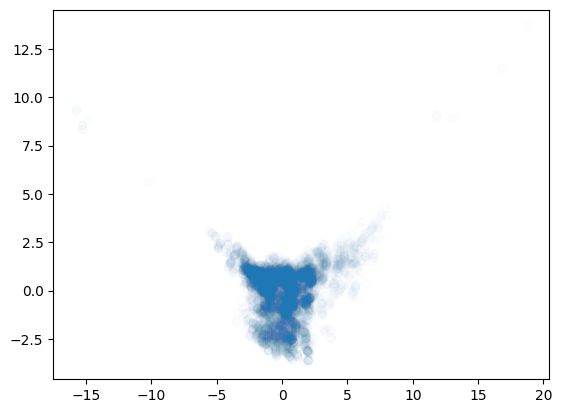

In [34]:
# Plotting the transformed data

plt.figure()
plt.scatter(X2D[:,0],X2D[:,1], alpha=0.01)

**Task:** Cluster the data using DBSCAN (`sklearn.cluster.DBSCAN`). Perform the clustering on the data which has not been dimensionality reduced. Plot the cluster centers along with the dimensionality reduced data.

Play around with different values for the `eps` argument and see what effect it has on the number of cluster centers.

**Hint:** You need to transformer the cluster centers through with same `PCA` object as the data. (Remember to only use `transform`, not `fit_transform`.

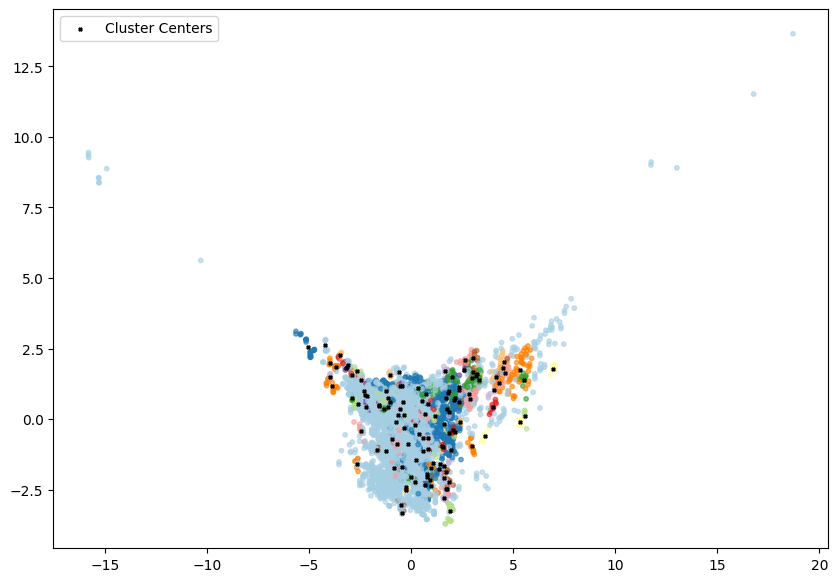

In [127]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.6, min_samples=5)
dbscan.fit(X_prepared)

labels = dbscan.labels_

unique_labels = set(labels) - {-1}
cluster_centers = np.array([
    X_prepared[labels == label].mean(axis=0)
    for label in unique_labels
])

X_centers_2D = pca.transform(cluster_centers)

plt.figure(figsize=(10, 7))
plt.scatter(X2D[:, 0], X2D[:, 1], c=labels, cmap='Paired', s=10, alpha=0.6)
plt.scatter(X_centers_2D[:, 0], X_centers_2D[:, 1], c='black', s=5, marker='X', label='Cluster Centers')
plt.legend()
plt.show()

**Task:** Cluster the data into five clusters using KMEANS (`sklearn.cluster.KMeans`). Plot the cluster centers along with the dimensionality reduced data.

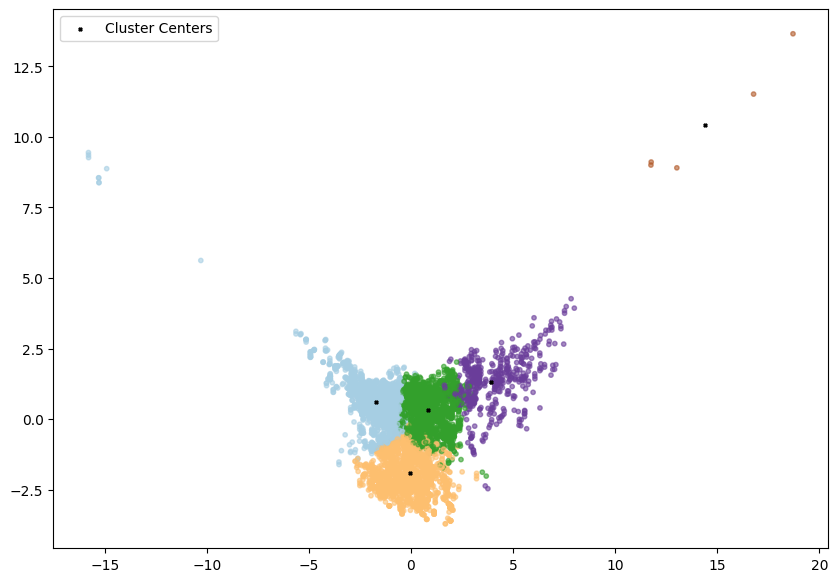

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=123)
kmeans.fit(X_prepared)
labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_
X_centers_2D = pca.transform(cluster_centers)
plt.figure(figsize=(10, 7))
plt.scatter(X2D[:, 0], X2D[:, 1], c=labels, cmap='Paired', s=10, alpha=0.6)
plt.scatter(X_centers_2D[:, 0], X_centers_2D[:, 1], c='black', s=5, marker='X', label='Cluster Centers')
plt.legend()
plt.show()

**Task:** Print the cluster centers.

In [71]:
print(X_centers_2D)

[[-1.70543741  0.60601191]
 [ 0.84098829  0.3236203 ]
 [-0.04166552 -1.91320505]
 [ 3.92862771  1.31839422]
 [14.40884456 10.44062373]]


**Task:** Cluster the data with KMeans again, but this time into 2 clusters. Plot the data, along with the cluster centers.

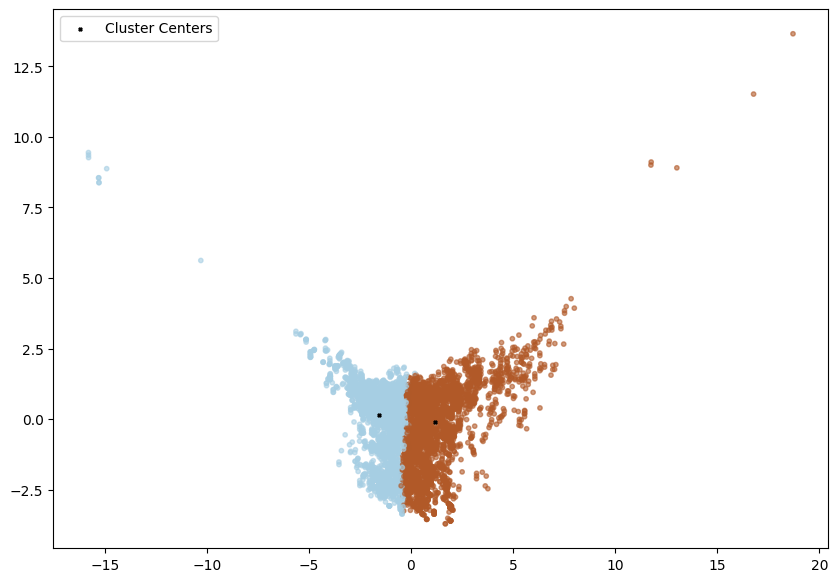

In [74]:
kmeans = KMeans(n_clusters=2, random_state=123)
kmeans.fit(X_prepared)
labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_
X_centers_2D = pca.transform(cluster_centers)
plt.figure(figsize=(10, 7))
plt.scatter(X2D[:, 0], X2D[:, 1], c=labels, cmap='Paired', s=10, alpha=0.6)
plt.scatter(X_centers_2D[:, 0], X_centers_2D[:, 1], c='black', s=5, marker='X', label='Cluster Centers')
plt.legend()
plt.show()

**Task:** Plot the silhouette score and inertia for different numbers of KMeans clusters. Try a range between 2 and 20 clusters.

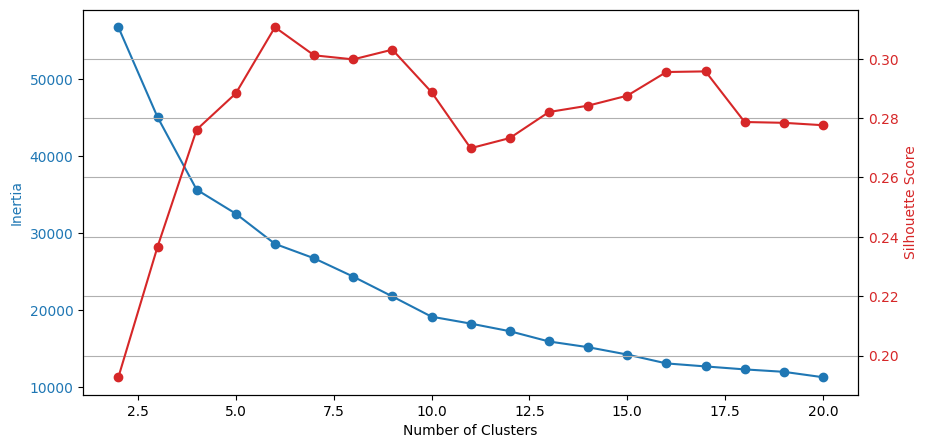

In [85]:
from sklearn.metrics import silhouette_score

inertia = []
silhouette = []

for i in range(2, 21):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_prepared)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_prepared, kmeans.labels_))

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.set_xlabel("Number of Clusters")
ax1.set_ylabel("Inertia", color='tab:blue')
ax1.plot(range(2, 21), inertia, marker='o', color='tab:blue', label='Inertia')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx() 
ax2.set_ylabel("Silhouette Score", color='tab:red') 
ax2.plot(range(2, 21), silhouette, marker='o', color='tab:red', label='Silhouette Score')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.grid()
plt.show()

**Task:** Cluster the data into five clusters using a Gaussian Mixture Model (`sklearn.mixture.GaussianMixture`). Perform ten initialization (by setting `n_init` to 10).

Print the `means_` and `weights_` attributes of the fitted model. 

Plot the cluster centers along with the dimensionality reduced data.

Means: [[-0.02164128  0.13447132  0.22981412  0.6328345  -0.28665351 -0.27762602
   0.02730561 -0.08673933]
 [-0.49758436 -0.18370803 -0.11050538 -1.647464   -0.01080759 -0.05071785
   0.05358762 -0.20026326]
 [ 0.62198304 -0.65247161 -0.96027568  0.6328345   1.04010401  1.01473444
  -0.2090187  -0.22523311]
 [ 0.29046133  2.70956467  2.28251478 -0.92170308 -1.0283062  -1.02008919
  -0.17269494  3.05256662]
 [-0.71001756 -0.3927508   0.3497715  -0.50731475 -1.04241115 -0.74172676
   0.84962664 -0.355785  ]]
Weights: [0.47663125 0.22832904 0.21414939 0.04814107 0.03274924]
Convergence: True


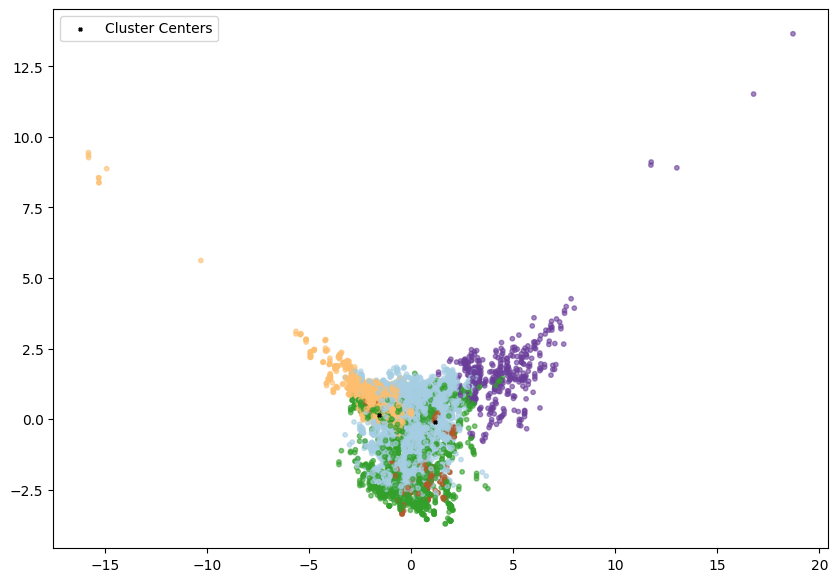

In [89]:
from sklearn.mixture import GaussianMixture

gauss = GaussianMixture(n_components=5, n_init=10, random_state=123)
gauss.fit(X_prepared)
labels = gauss.predict(X_prepared)
print(f"Means: {gauss.means_}")
print(f"Weights: {gauss.weights_}")
print(f"Convergence: {gauss.converged_}")

#plot the cluster centers along with the dimensionality reduced data
plt.figure(figsize=(10, 7))
plt.scatter(X2D[:, 0], X2D[:, 1], c=labels, cmap='Paired', s=10, alpha=0.6)
plt.scatter(X_centers_2D[:, 0], X_centers_2D[:, 1], c='black', s=5, marker='X', label='Cluster Centers')
plt.legend()
plt.show()

**Question:** Did the algorithm converge?

**Answer:** `Yes`

**Task:** Plot the BIC and AIC for different numbers of Gaussian Mixture clusters. Try a range between 2 and 50 clusters.

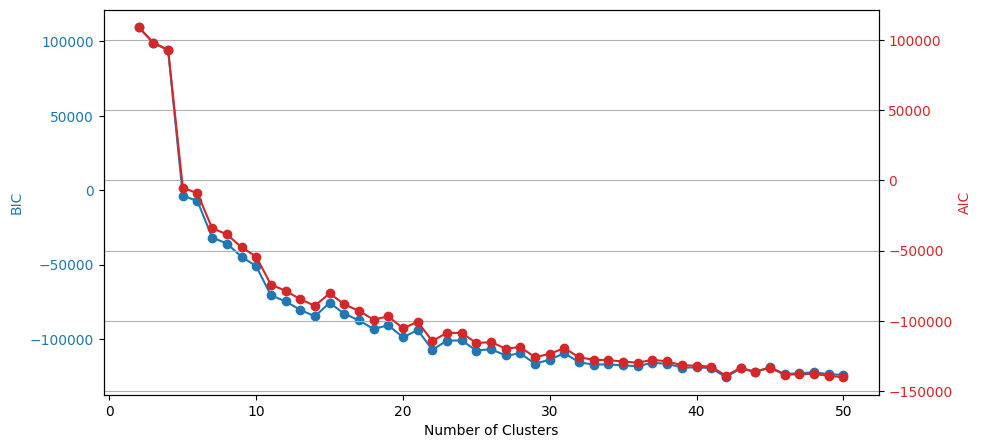

In [91]:
n_components = range(2, 51)
bic = []
aic = []
for n in n_components:
    gauss = GaussianMixture(n_components=n, n_init=2, random_state=123)
    gauss.fit(X_prepared)
    bic.append(gauss.bic(X_prepared))
    aic.append(gauss.aic(X_prepared))

fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.set_xlabel("Number of Clusters")
ax1.set_ylabel("BIC", color='tab:blue')
ax1.plot(n_components, bic, marker='o', color='tab:blue', label='BIC')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel("AIC", color='tab:red')
ax2.plot(n_components, aic, marker='o', color='tab:red', label='AIC')
ax2.tick_params(axis='y', labelcolor='tab:red')
plt.grid()
plt.show()

**Question:** Judging by this plot, what do you think are a good number of Gaussian Mixture clusters for this dataset?

**Answer:** `Around 20 (using the elbow method)`

**Task**: Find anomalies using the Gaussian mixture model. Pick a density threshold such that approximately 0.1% of the instances will be considered anomalies (see the section on Anomaly Detection Using Gaussian Mixtures in the text book). Which examples in the data are classified as anomalies?

Number of anomalies: 9
Anomalies: [[ 4.72167808e-01 -1.00567525e+00 -3.23679264e+00  6.32834504e-01
   1.21191560e+01  1.63539115e+01 -1.12646491e-01 -2.23616816e-01]
 [ 7.37376606e-01 -1.00567525e+00 -3.23679264e+00  6.32834504e-01
   1.21191560e+01  1.63539115e+01 -1.12646491e-01 -2.48739025e-01]
 [ 8.69981005e-01 -7.30275895e-01 -3.23679264e+00  6.32834504e-01
   1.24122481e+01  1.77085658e+01  1.65101088e+00  2.86486846e-02]
 [ 7.37376606e-01 -7.30275895e-01 -3.23679264e+00  6.32834504e-01
   1.24122481e+01  1.77085658e+01  1.65101088e+00  2.86486846e-02]
 [ 4.72167808e-01 -1.00567525e+00 -3.23679264e+00  6.32834504e-01
   1.21191560e+01  1.63539115e+01 -1.12646491e-01 -2.18399744e-01]
 [ 8.69981005e-01 -7.30275895e-01 -3.23679264e+00  6.32834504e-01
   1.16795178e+01  1.65044286e+01  1.65101088e+00  4.79117200e-02]
 [ 6.04772207e-01 -7.30275895e-01 -3.23679264e+00  6.32834504e-01
   1.24122481e+01  1.77085658e+01  1.65101088e+00  2.86486846e-02]
 [ 7.37376606e-01 -6.66016045e-01 -

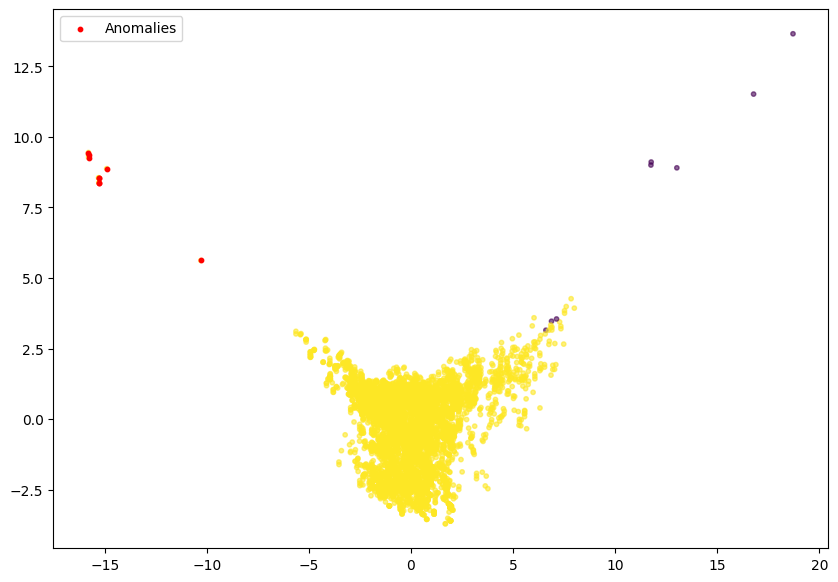

In [123]:
gauss = GaussianMixture(n_components=5, n_init=10, random_state=123)
gauss.fit(X_prepared)

density = gauss.score_samples(X_prepared) # log likelihood of each sample
threshold = np.percentile(density, 0.1) # 0.1% of the data is considered as anomalies
anomalies = X_prepared[density < threshold] # get the samples with log likelihood below the threshold
print(f"Number of anomalies: {len(anomalies)}")
print(f"Anomalies: {anomalies}")

# print the anomalies in a scatter plot
plt.figure(figsize=(10, 7))
plt.scatter(X2D[:, 0], X2D[:, 1], c=labels, cmap='viridis', s=10, alpha=0.6)
plt.scatter(X2D[density < threshold, 0], X2D[density < threshold, 1], c='red', s=10, label='Anomalies')
plt.legend()
plt.show()

**Task:** Use an Isolation Forest model (`sklearn.ensemble.IsolationForest`) to find the outliers in the data. Assume that the proportion of outliers is 0.1%.

Print some of the outliers and hypothesize why they are classified as outliers.

Number of anomalies: 8
Anomalies: [[ 0.20695901  3.40071447  3.64027498  0.6328345  -1.50962814 -1.40711256
  -1.03105835  6.07322867]
 [ 0.20695901  3.40071447  3.64027498  0.6328345  -1.50962814 -1.40711256
  -1.03105835  6.89832868]
 [ 0.07435461  3.40071447  3.64027498  0.6328345  -1.50962814 -1.40711256
  -1.03105835 21.50051213]
 [ 0.20695901  3.40071447  3.64027498  0.6328345  -1.50962814 -1.40711256
  -1.03105835 21.54465659]
 [-0.32345859  6.89828632  5.93263085 -1.647464   -1.80272027 -1.70814686
  -0.50635112 32.51097422]
 [-0.05824979  3.50169424  3.64027498  0.6328345  -1.50962814 -1.40711256
  -1.03105835  7.47862762]
 [-0.19085419  6.89828632  5.93263085 -1.647464   -1.80272027 -1.70814686
  -0.50635112 26.72992861]
 [-0.32345859  3.67611383  3.64027498 -1.647464   -1.80272027 -1.55762971
  -0.27082516 23.42681567]]


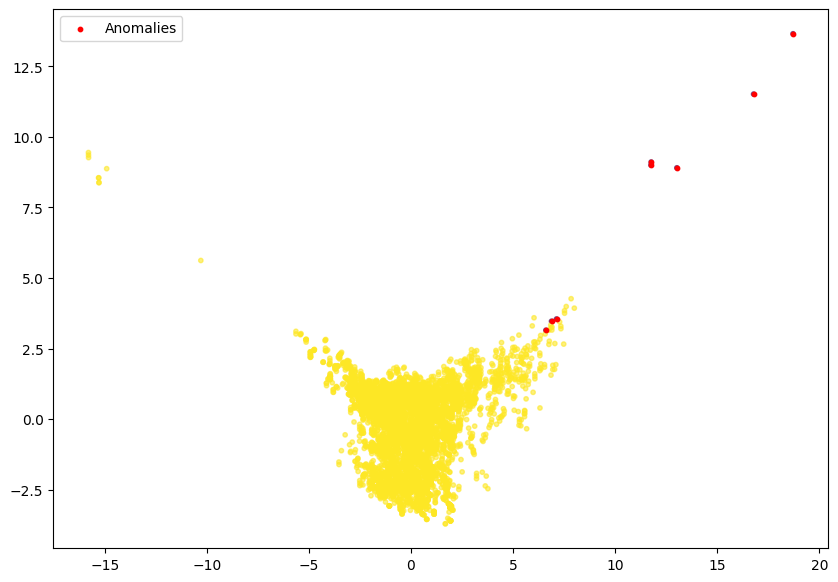

In [124]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(contamination=0.001, random_state=123)
iso_forest.fit(X_prepared)
labels = iso_forest.predict(X_prepared)
anomalies = X_prepared[labels == -1]
print(f"Number of anomalies: {len(anomalies)}")
print(f"Anomalies: {anomalies}")

# print the anomalies in a scatter plot
plt.figure(figsize=(10, 7))
plt.scatter(X2D[:, 0], X2D[:, 1], c=labels, cmap='viridis', s=10, alpha=0.6)
plt.scatter(X2D[labels == -1, 0], X2D[labels == -1, 1], c='red', s=10, label='Anomalies')
plt.legend()
plt.show()